### Summary of feature selection
Some key take aways from the feature selection:
- Different algorithms categorize different features with higher rank then others. 
- The feature rank is dynamic through time
## Classification
### Which features to use

Since the feature selection is  bit unclear I will run with some different configurations
- Baseline by nomask variables

### Mitigating small sample size
- Since the sample size is small I will performe the analysis using ensamble learners, therefor we start with random forest. 
- Further use a range of seeds to mitigate the effect that random sampling plays in makeing the classification harder or easier.

### Random Forest tuning 
- The RF is retuned for every new seed

The code will have the following structure:
- Iterate through every year in the near term temporal range (-2040)
- for each year we:
    - Itertate through every feature selection
    - for each selection we:
        - iterate throgh different seeds
        - for each seed we:
            - performe test-train split
            - tune model
            - return best model
            - retrain model on whole training set
            - pred on test and evaluate performance
            - return performance
        - average best models from each seed
            - retrain on this avereged model on every seed 
            - return performance
    - Evaluate performance across every seed and compare feature selection
    
From this we need:
- function that tune model and returns best model tuning
- function that extract performance 
- function that plots the seed-ensamble across years

### Helper functions

In [1]:
def tune_RF(X_train, y_train, seed):
    
    param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_depth': [None] + [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=seed)
    random_search = RandomizedSearchCV(estimator=rf, 
                                       param_distributions=param_grid, 
                                       n_iter=100, # Covers more feature combinations (here 100 out of 4320)
                                       cv=5, # higher num decreases chance of overfitting
                                       verbose=0, 
                                       random_state=seed, 
                                       n_jobs = -1)
    random_search.fit(X_train, y_train)

    return random_search

In [2]:
def create_best_model(params_best_rf):
    keys = params_best_rf[0].keys()

    all_models = {key: [] for key in keys}
    for key in keys:
        all_models[key] = [best_rf[key] for best_rf in params_best_rf]

    averaged_model = {}
    for key in all_models.keys():
        values = all_models[key]
        if all(isinstance(value, (int, float)) for value in values):
            averaged_model[key] = statistics.mean(values)
        else:
            averaged_model[key] = statistics.mode(values)

    return averaged_model

'''
averaged_model = create_best_model(params_best_rf)
        averaged_rf = RandomForestClassifier(averaged_model)

        for seed in tqdm(range(5)):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
            
            y_pred = averaged_rf.predict(X_test)
'''

'\naveraged_model = create_best_model(params_best_rf)\n        averaged_rf = RandomForestClassifier(averaged_model)\n\n        for seed in tqdm(range(5)):\n            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)\n            \n            y_pred = averaged_rf.predict(X_test)\n'

In [3]:
def summarize_classification_and_add_dfrow(y_pred, y_test, seed, df_summaryallseeds):
    summary_dict = {'seed': seed}
    summary_dict['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    summary_dict['error'] = 1 - summary_dict['accuracy']
    summary_dict['precision'], summary_dict['recall'], summary_dict['f1-score'], _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='binary')
    summary_dict['support'] = len(y_test)
    
    for key, value in summary_dict.items():
        if key not in  ['support', 'seed']:
            summary_dict[key] = round(value, 2)
    
    new_row = summary_dict.values()
    df_summaryallseeds.loc[seed] = list(new_row)
    
    return df_summaryallseeds

### import libraries

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import statistics

from src.plotting import *
import seaborn as sns 
import matplotlib.pyplot as plt

We start by importing the data

In [5]:
scenario_indx_key = {'ssp126': 0, 'ssp585': 1}
years = list(range(2015, 2050))
scaled_cross_sections = {year: pd.read_csv('/'.join(['/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/standardscaled', f'cross_section_{year}_standscaled.csv'])) for year in years}
for year in years:
    scaled_cross_section = scaled_cross_sections[year]
    scaled_cross_section['scenario_indx'] = scaled_cross_section['scenario'].map(scenario_indx_key)
    scaled_cross_section['scenario_indx'] = scaled_cross_section['scenario_indx'].astype('Int64')
    scaled_cross_sections[year] = scaled_cross_section[scaled_cross_section['scenario'].isin(['ssp126', 'ssp585'])]

### Performe classification

In [6]:
boruta_decisions_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/boruta_decisions_df.csv').drop(columns=['Unnamed: 0'])

boruta_dynamic_features = {}
for index, row in boruta_decisions_df.iterrows():
    column_names = []
    for col in boruta_decisions_df.columns:
        if row[col] == 2:
            column_names.append(col)

    column_names = [col.replace('..', ': ') for col in column_names]
    boruta_dynamic_features[row['year']] = column_names

In [7]:
nomask_features = ['fdETCCDI: nomask', 'gslETCCDI: nomask', 'pr: nomask', 'tas: nomask', 'txxETCCDI: nomask']
cumulative_mRMR_features = ['fdETCCDI: nomask', 'gslETCCDI: nomask', 'pr: nomask', 'tas: nomask', 'tas: land_mask', 'tas: sea_mask', 'txxETCCDI: nomask', 'txxETCCDI: sea_mask']


feature_combinations = {'nomask_baseline': nomask_features, 
                        'cumulative_mRMR': cumulative_mRMR_features, 
                        'boruta_dynamic': boruta_dynamic_features}

In [9]:
seeds = [int(i) for i in range(100)]
classification_summaries = {feature_comb_key: {} for feature_comb_key in feature_combinations.keys()}
confusion_matrices = {feature_comb_key: {} for feature_comb_key in feature_combinations.keys()}

#years = [int(2020+i) for i in range(21)]
years =  [2030, 2035, 2040]
for year in tqdm(years):
    cross_section_df = scaled_cross_sections[year]

    for feature_comb_key, feature_comb in feature_combinations.items():
        if isinstance(feature_comb, dict):
            feature_comb = feature_comb[year]
            if len(feature_comb) == 0:
                continue
            
        X = cross_section_df[feature_comb]
        y = cross_section_df['scenario_indx']

        df_summaryallseeds = pd.DataFrame(columns=['seed', 'accuracy', 'error', 'precision', 'recall', 'f1-score', 'support'], 
                                          index=range(len(seeds)))
        cm_all_seeds = []     
        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
            
            grid_search = tune_RF(X_train, y_train, seed)
#            params_best_rf.append(grid_search.best_params_)
            best_rf = grid_search.best_estimator_

            y_pred = best_rf.predict(X_test)
            cm_all_seeds.append(confusion_matrix(y_true=y_test, y_pred=y_pred))
            df_summaryallseeds = summarize_classification_and_add_dfrow(y_pred, y_test, seed, df_summaryallseeds)
        
        classification_summaries[feature_comb_key][year] = df_summaryallseeds
        average_cm = (sum(cm_all_seeds) / (len(cm_all_seeds)*24)*100).astype(float).round(2)
        confusion_matrices[feature_comb_key][year] = average_cm

100%|██████████| 3/3 [02:30<00:00, 50.05s/it]


In [10]:
def plot_cms(confusion_matrices, years=None, feature_comb_keys=None):
    
    scenario_indx_key = {'ssp126': 0, 'ssp585': 1}

    included_years = years if years is not None else list(next(iter(confusion_matrices.values())).keys())
    included_feature_combs = feature_comb_keys if feature_comb_keys is not None else list(confusion_matrices.keys())

    nrows = len(included_years)
    ncols = len(included_feature_combs)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows), sharey='row')
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    fig.suptitle('Mean confusion matrices across seeds', fontsize=22)

    for row, year in enumerate(included_years):
        for col, feature_comb_key in enumerate(included_feature_combs):
            ax = axs[row, col]
            data = confusion_matrices[feature_comb_key][year]
            data_df = pd.DataFrame(data)
            data_str = data_df.map(lambda x: f'{x:.2f}%')            
            sns.heatmap(data_df, annot=data_str, fmt='', cmap='Blues', ax=ax, vmax=50, vmin=0, cbar=False)
            ax.set_title(f'{feature_comb_key} ({year})')
    
            # Set y-axis and x-axis labels using scenario_indx_key
            ax.set_yticklabels([key for key, value in scenario_indx_key.items()], rotation=45)
            ax.set_xticklabels([key for key, value in scenario_indx_key.items()], rotation=0)

    
    plt.colorbar(ax.collections[0], cax=cbar_ax, format='%.0f%%')
    plt.show()

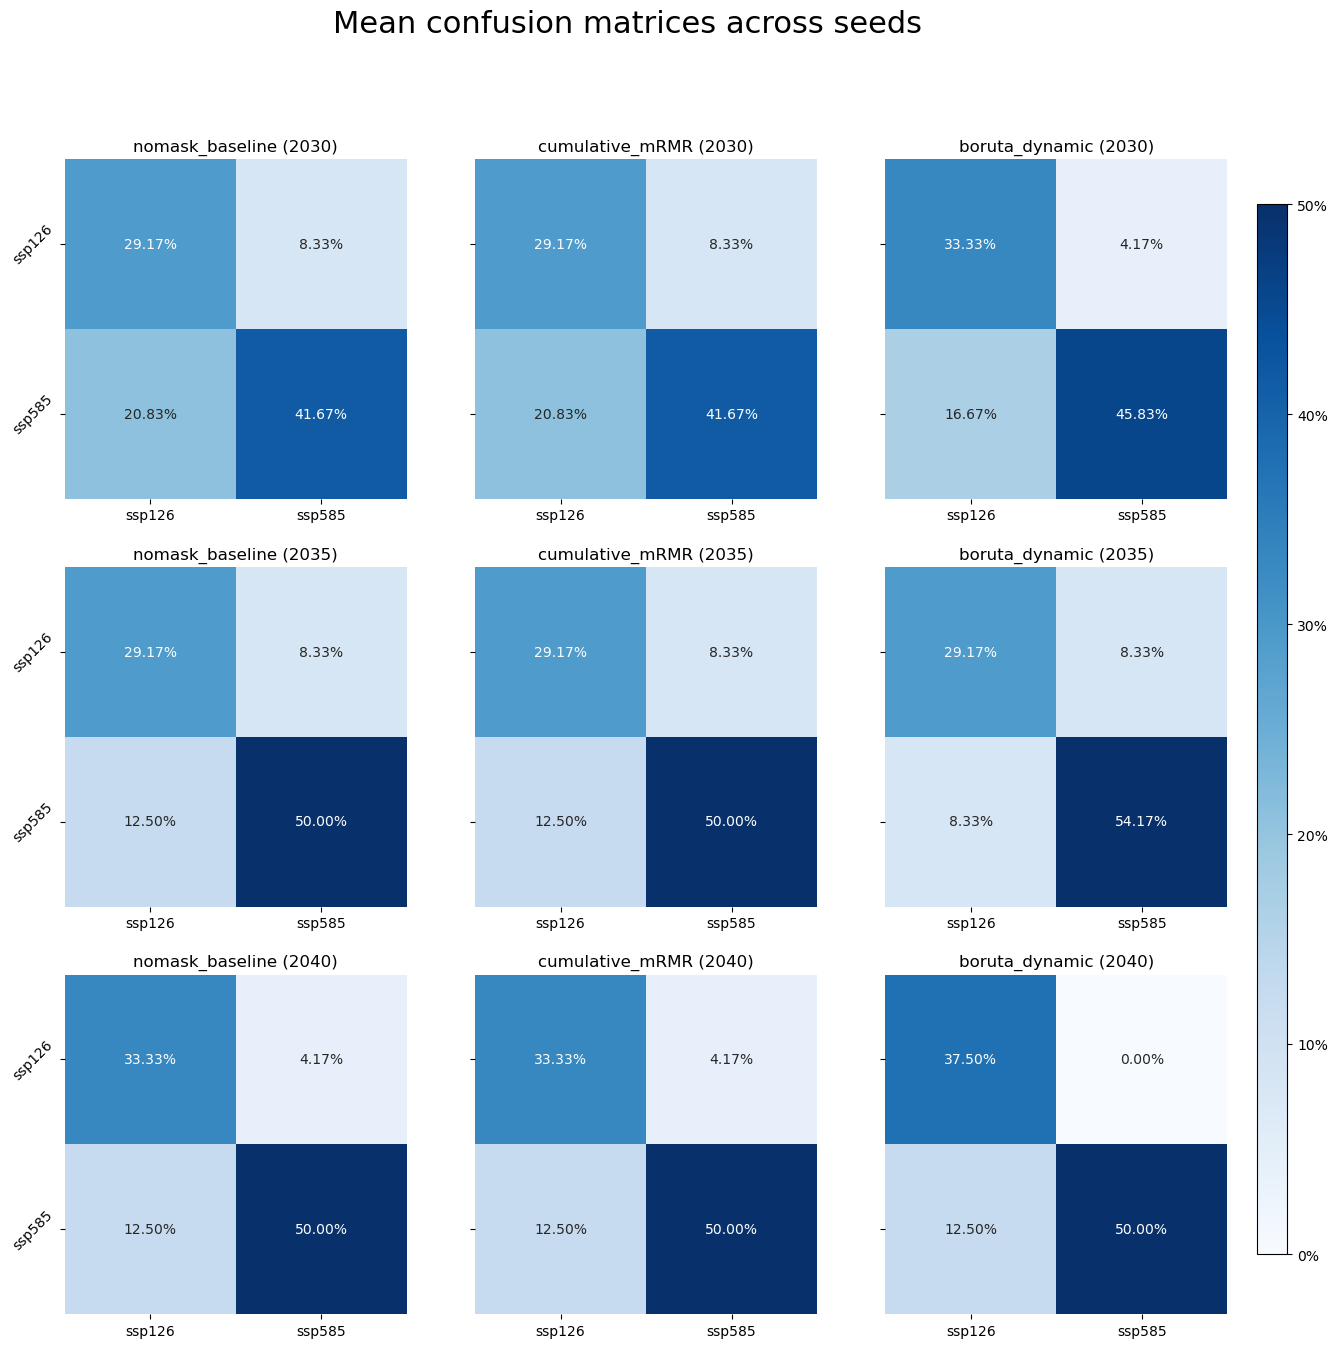

In [11]:
plot_cms(confusion_matrices)

In [12]:
def plot_performance(classification_summaries, metric):

    plot_data = pd.DataFrame(columns=['Year', metric, 'feature_comb_key'])

    for feature_comb_key, classification_summary in classification_summaries.items():
        accuracy_feature_comb = []
        year_list = []
        for year in years:
            if year in classification_summary.keys():
                accuracy_feature_comb = accuracy_feature_comb + classification_summary[year][metric].tolist()
                year_list = year_list + [year for _ in range(len(classification_summary[year][metric].tolist()))]
        
        feature_comp_plot_data = pd.DataFrame({'Year': year_list,
                                               'accuracy': accuracy_feature_comb, 
                                               'feature_comb_key': [feature_comb_key for _ in range(len(accuracy_feature_comb))]})
        plot_data = pd.concat([plot_data, feature_comp_plot_data], ignore_index=True)


    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.suptitle(f'{metric.capitalize()} development using Random Forest classifier')  # Add the suptitle
    sns.lineplot(data=plot_data, x='Year', y='accuracy', errorbar='sd', hue='feature_comb_key')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)  # Put the legend below the plot
    plt.xticks(np.arange(min(plot_data['Year']), max(plot_data['Year'])+1, 2))  # Make x-axis tick labels integers
    plt.show()

/tmp/ipykernel_1180174/2728832439.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, feature_comp_plot_data], ignore_index=True)


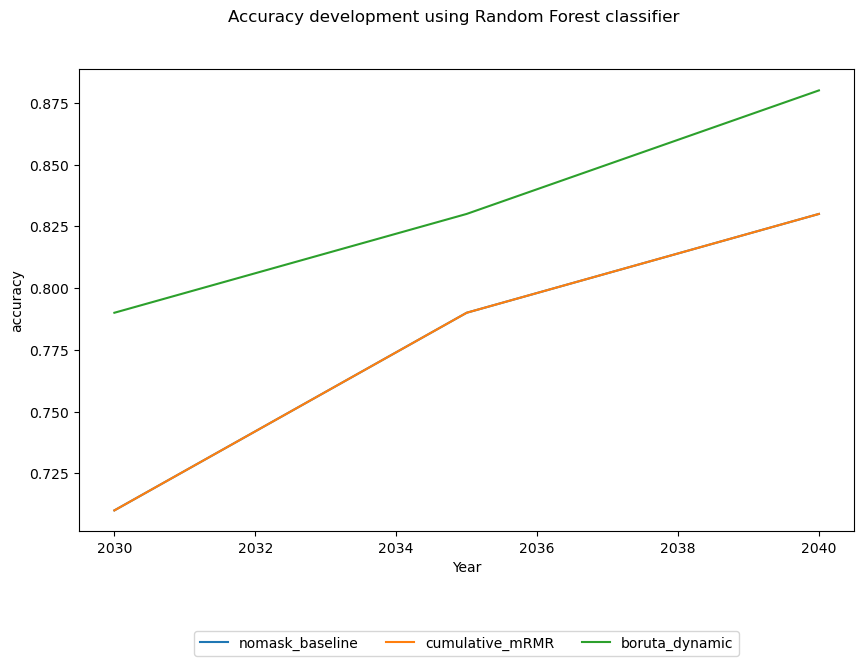

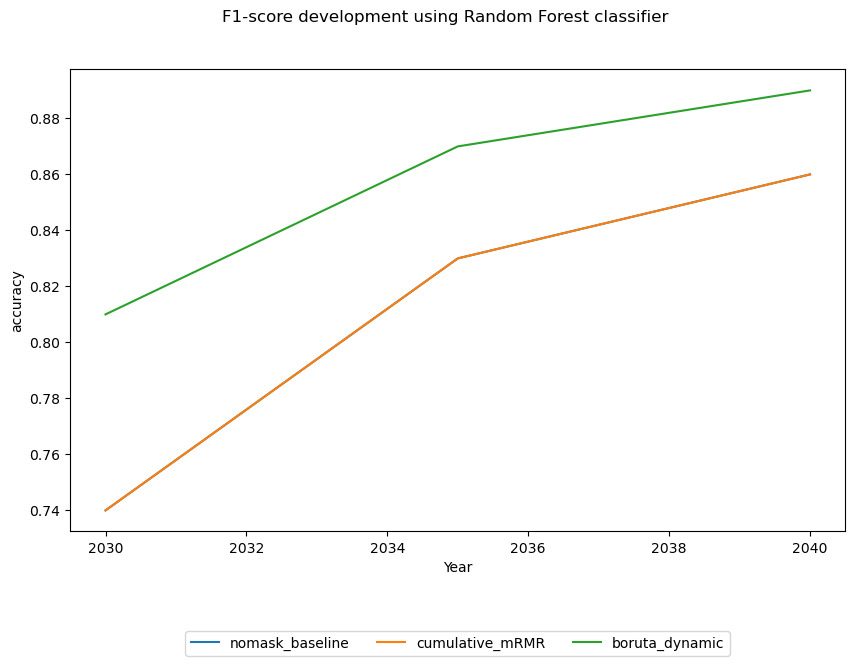

In [13]:
plot_performance(classification_summaries, 'accuracy')
plot_performance(classification_summaries, 'f1-score')

dynamic er litt kunstigt? benytte de features som er approved for perioden 2030-2040? gjelder kanskje de andre feature algoritmene også. 
- Boruta SHAP istede (kan brukes på alle trebaserte algoritmer)
- ensambling generelt også for svm 


## add?

Feature importance for model?

In [ ]:
feature_importance = pd.DataFrame()
cross_section_df = scaled_cross_sections[2030]

X = cross_section_df[nomask_features]
y = cross_section_df['scenario_indx']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

grid_search = tune_RF(X_train, y_train, 12)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

feature_importance['features'] = nomask_features
feature_importance['inpuritybased_importance'] = best_rf.feature_importances_

perm_results = permutation_importance(best_rf, X_train, y_train, n_repeats=10, n_jobs=-1, random_state=12)

feature_importance['permutation_importance (mean)'] = perm_results.importances_mean
feature_importance['permutation_importance (sd)'] = perm_results.importances_std

feature_importance